In [1]:
# Loading in the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import re

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bensioninoyatov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/bensioninoyatov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bensioninoyatov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
main = pd.read_csv('main1.csv')
main.drop(columns='Unnamed: 0', inplace=True)

In [3]:
main

,text,label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,1
1,Watch The Exact Moment Paul Ryan Committed Pol...,1
2,Kerry to go to Paris in gesture of sympathy U....,0
3,Bernie supporters on Twitter erupt in anger ag...,1
4,The Battle of New York: Why This Primary Matte...,0
...,...,...
26533,Rapper T.I.: Trump a ’Poster Child For White S...,0
26534,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",0
26535,Macy’s Is Said to Receive Takeover Approach by...,0
26536,"NATO, Russia To Hold Parallel Exercises In Bal...",1


### Dummy Classifier to start

In [4]:
X = main['text']
y = main['label']
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X,y)
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.5108900444645414

- As expected the dummy classifier score is roughly guessing the most frequent class
---
### TFIDF and Passive Aggressive Classifier (PAC)
- Only tfidf pre-processing here
- PACs are good for text data

In [5]:
# Splitting into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.7, random_state=1, shuffle=True)

In [6]:
# Instantiating the tfidf object
tfidf_vectorizer=TfidfVectorizer(stop_words='english')

In [7]:
# Vectorizing data so that we can use it in model process 
vec_train=tfidf_vectorizer.fit_transform(X_train)
vec_test=tfidf_vectorizer.transform(X_test)

In [8]:
# Instantiating the classifier and fitting vectorized data 
pac=PassiveAggressiveClassifier(max_iter=1000, random_state=1, C=.055)
pac.fit(vec_train,y_train)

PassiveAggressiveClassifier(C=0.055, random_state=1)

In [9]:
# Predicting on the test data and getting an accuracy score 
y_pred=pac.predict(vec_test)
score=accuracy_score(y_test,y_pred)
print(f'PAC Accuracy: {round(score*100,2)}')
score

PAC Accuracy: 96.13


0.9613162521979403

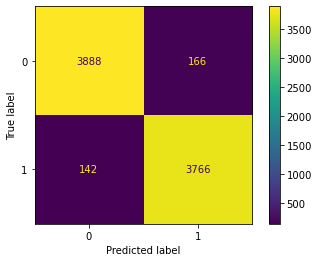

In [10]:
plot_confusion_matrix(pac, vec_test, y_test)

- So far, accuracy is decent with a classifier that  and term frequency vectorizing. Further processing may improve this score 
---
### PAC with articles tokenized and stop words removed

In [16]:
working_text = pd.read_csv('working_text.csv')
working_text.drop(columns='Unnamed: 0', inplace=True)
working_text

,text
0,smell hillary fear daniel greenfield shillman ...
1,watch exact moment paul ryan committed politic...
2,kerry go paris gesture sympathy u.s. secretary...
3,bernie supporters twitter erupt anger dnc 'we ...
4,battle new york primary matters primary day ne...
...,...
26533,rapper t.i trump poster child white supremacy ...
26534,n.f.l playoffs schedule matchups odds new york...
26535,macy said receive takeover approach hudson bay...
26536,nato russia hold parallel exercises balkans na...


In [84]:
X_train_token, X_test_token, y_train, y_test = train_test_split(working_text['text'], main['label'],
                                                               train_size = 0.7, random_state=1, shuffle=True)

In [85]:
# Vectorizing data so that we can use it in model process 
vec_train2=tfidf_vectorizer.fit_transform(X_train_token)
vec_test2=tfidf_vectorizer.transform(X_test_token)

In [86]:
# Instantiating the classifier and fitting to the new vectorized data 
pac2=PassiveAggressiveClassifier(max_iter=50, random_state=1, C=.05, class_weight='balanced', shuffle=True)
pac2.fit(vec_train2, y_train)

PassiveAggressiveClassifier(C=0.05, class_weight='balanced', max_iter=50,
                            random_state=1)

In [87]:
# Predicting on the new test data and getting an accuracy score 
y_pred2=pac2.predict(vec_test2)
score=accuracy_score(y_test,y_pred2)
print(f'PAC Accuracy: {round(score*100,2)}')
score

PAC Accuracy: 96.16


0.9615674453654861

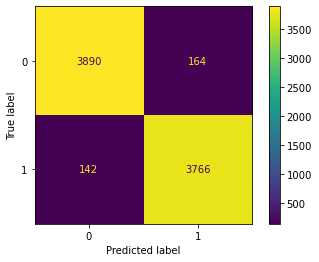

In [92]:
plot_confusion_matrix(pac2, vec_test2, y_test);

### Gridsearch of PAC params with 5 folds of cross validation

In [ ]:
pacgscv = PassiveAggressiveClassifier(random_state=1, C=.05)
params = {
    'max_iter': range(20,1000,30),
    'shuffle': [True, False],
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced']
}
gs = GridSearchCV(pacgscv, param_grid=params, n_jobs=-1, verbose=1, cv=5)

In [ ]:
gs.fit(vec_train2, y_train)

- Paramaters optimized by gridsearchcv for PAC. Best accuracy score is 96.16
- We can try further text processing to try and get a better score 
---
### PAC with lemmatization 

In [25]:
lemma_text = pd.read_csv('lemma_text.csv')
lemma_text.drop(columns='Unnamed: 0', inplace=True)
lemma_text

,text
0,smell hillary fear daniel greenfield shillman ...
1,watch exact moment paul ryan committed politic...
2,kerry go paris gesture sympathy u.s. secretary...
3,bernie supporter twitter erupt anger dnc 'we t...
4,battle new york primary matter primary day new...
...,...
26533,rapper t.i trump poster child white supremacy ...
26534,n.f.l playoff schedule matchup odds new york t...
26535,macy said receive takeover approach hudson bay...
26536,nato russia hold parallel exercise balkan nato...


In [26]:
# Splitting into train and test sets for new lemma data 
X_train_lemma, X_test_lemma, y_train, y_test = train_test_split(lemma_text['text'], main['label'], 
                                                    train_size = 0.7, random_state=1, shuffle=True)

In [27]:
# Vectorizing data so that we can use it in model process 
vec_train3=tfidf_vectorizer.fit_transform(X_train_lemma)
vec_test3=tfidf_vectorizer.transform(X_test_lemma)

In [40]:
# Instantiating the classifier and fitting to the new vectorized data 
pac3=PassiveAggressiveClassifier(max_iter=50, random_state=1, C=.05, class_weight='balanced')
pac3.fit(vec_train3, y_train)

PassiveAggressiveClassifier(C=0.05, class_weight='balanced', max_iter=50,
                            random_state=1)

In [41]:
# Predicting on the new test data and getting an accuracy score 
y_pred3=pac3.predict(vec_test3)
score=accuracy_score(y_test,y_pred3)
print(f'PAC Accuracy: {round(score*100,2)}')
score

PAC Accuracy: 96.03


0.9603114795277569

- Lemmatized words performed just a bit worse but only marginally 
### PAC with stemming 

In [42]:
stem_text = pd.read_csv('stem_text.csv')
stem_text.drop(columns='Unnamed: 0', inplace=True)
stem_text

,text
0,smell hillari fear daniel greenfield shillman ...
1,watch exact moment paul ryan commit polit suic...
2,kerri go pari gestur sympathi u.s. secretari s...
3,berni support twitter erupt anger dnc 'we tri ...
4,battl new york primari matter primari day new ...
...,...
26533,rapper t.i trump poster child white supremaci ...
26534,n.f.l playoff schedul matchup odd new york tim...
26535,maci said receiv takeov approach hudson bay ne...
26536,nato russia hold parallel exercis balkan nato ...


In [43]:
X_train, X_test, y_train, y_test = train_test_split(stem_text['text'], main['label'], random_state=1, 
                                                    shuffle=True, train_size=0.7)

vec_train=tfidf_vectorizer.fit_transform(X_train)
vec_test=tfidf_vectorizer.transform(X_test)

In [70]:
pacStem=PassiveAggressiveClassifier(max_iter=1000, random_state=1, C=.045, class_weight='balanced', shuffle=True)
pacStem.fit(vec_train, y_train)

PassiveAggressiveClassifier(C=0.045, class_weight='balanced', random_state=1)

In [71]:
ypredstem = pacStem.predict(vec_test)
score = accuracy_score(y_test, ypredstem)
score

0.9586787239387089

---
### Random Forest with gridsearchcv

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
X = main['text']
y = main['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size = 0.7, random_state=1, shuffle=True)

vec_train=tfidf_vectorizer.fit_transform(X_train)
vec_test=tfidf_vectorizer.transform(X_test)

rfc = RandomForestClassifier(verbose=1, n_jobs=-1, random_state=1)
rfc.fit(vec_train, y_train)
ypred = rfc.predict(vec_test)
accuracy_score(y_test, ypred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished


0.9318010550113037

In [80]:
rfc = RandomForestClassifier(verbose=1, n_jobs=-1, random_state=1)
param = {'n_estimators': range(50,200,25),
         'max_depth' : range(5,50,10),
         'criterion': ['gini', 'entropy']}
rfcgs = GridSearchCV(rfc, param, n_jobs=-1, verbose=1, cv=3)
rfcgs.fit(vec_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 27.1min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   27.3s finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=1,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 50, 10),
                         'n_estimators': range(50, 200, 25)},
             verbose=1)

In [81]:
rfcgs.best_params_

{'criterion': 'entropy', 'max_depth': 45, 'n_estimators': 175}

In [83]:
rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 100,
                             verbose=1, n_jobs=-1, random_state=1,
                            n_estimators=175)
rfc.fit(vec_train,y_train)
ypred = rfc.predict(vec_test)
accuracy_score(y_test, ypred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:   48.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed:    2.8s finished


0.9351921627731725

---
- PAC performed best 

---
### Visualization

In [15]:
freq_fake = main[main['label']==1]
freq_real = main[main['label']==0]

In [16]:
data_fake = freq_fake['text']
data_real = freq_real['text']

In [17]:
def process_article1(article):
    article = article.lower()
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed
cleaned_fake = list(map(process_article1, data_fake))
cleaned_real = list(map(process_article1, data_real))

In [18]:
flat_fake = [item for sublist in cleaned_fake for item in sublist]
flat_true = [item for sublist in cleaned_real for item in sublist]

In [21]:
fake_freq = FreqDist(flat_fake)
real_freq = FreqDist(flat_true)

In [27]:
fake_freq.most_common(200)

[('trump', 27733),
 ('clinton', 26677),
 ('people', 21789),
 ('one', 20432),
 ('us', 19435),
 ('would', 19401),
 ('hillary', 18448),
 ('said', 15771),
 ('new', 14360),
 ('like', 13284),
 ('also', 13031),
 ('world', 12284),
 ('even', 11656),
 ('election', 11485),
 ('time', 11482),
 ('state', 11233),
 ('``', 11093),
 ('—', 10786),
 ('government', 10540),
 ('many', 10518),
 ('president', 10460),
 ('could', 10126),
 ('2016', 10116),
 ('war', 9970),
 ('obama', 9890),
 ('‘', 9477),
 ('russia', 8993),
 ('american', 8970),
 ('states', 8752),
 ('media', 8650),
 ('years', 8582),
 ('get', 8433),
 ('first', 8414),
 ('campaign', 8097),
 ('u.s.', 8096),
 ('know', 7835),
 ('may', 7827),
 ('two', 7559),
 ('donald', 7452),
 ('news', 7373),
 ('america', 7340),
 ('way', 7213),
 ('fbi', 7183),
 ('see', 7177),
 ('make', 7121),
 ('country', 7058),
 ('going', 6915),
 ('political', 6886),
 ('de', 6685),
 ('united', 6658),
 ('well', 6644),
 ('think', 6517),
 ('much', 6433),
 ('right', 6239),
 ('back', 6153),
 

In [23]:
real_freq.most_common(20)

[('said', 85402),
 ('mr.', 65016),
 ('trump', 54317),
 ('—', 45436),
 ('new', 32252),
 ('would', 30922),
 ('one', 29028),
 ('people', 26299),
 ('president', 23089),
 ('also', 20565),
 ('like', 19950),
 ('clinton', 19352),
 ('state', 17756),
 ('``', 17201),
 ('could', 16249),
 ('time', 15583),
 ('states', 14986),
 ('two', 14867),
 ('many', 14585),
 ('york', 14437)]

In [24]:
fake_bar_counts = [x[1] for x in fake_freq.most_common(25)]
fake_bar_words = [x[0] for x in fake_freq.most_common(25)]

real_bar_counts = [x[1] for x in real_freq.most_common(25)]
real_bar_words = [x[0] for x in real_freq.most_common(25)]

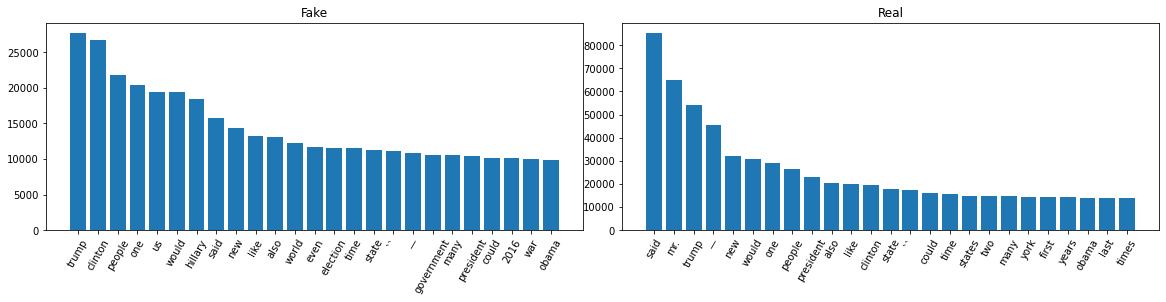

In [25]:
new_figure = plt.figure(figsize=(16,4))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(fake_bar_words, fake_bar_counts)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(real_bar_words, real_bar_counts)

ax.title.set_text('Fake')
ax2.title.set_text('Real')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()